In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [4]:
import json
with open("/content/drive/MyDrive/negacio_uab_revised_version.json","r") as f:
    data = json.load(f)
data

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/negacio_uab_revised_version.json'

data -> array. Each cell is one "historia clinica" entry

data[0] -> dictionary with "data" and "anotations" and "predictions"

        -> "data" would be the "x". Contains id, actual text. And other data.

        -> "annotations" seems to be empty
        
        -> "predictions" our "y", "label". Contains the tags for indexes of the text.

data[0]["predictions"][0] <- for some reason nested inside an unnecessary array

data[0]["predictions"][0]["result"] <- also nested inside unnecessary dictionary with one key


data[0]["predictions"][0]["result"] -> inside here we have a list of tags for different ranges.

data[0]["predictions"][0]["result"][0] -> in each of these elements of the list, we have another dictionary

data[0]["pred2ictions"][0]["result"][0]["value"] -> to access a dictionary with the keys "start", "end", and "labels". For start, end index and the tag

data[0]["pred2ictions"][0]["result"][0] -> we have more keys such as "id", "from_name", "to_name" and "type". Use?? differentiate if is label or not? what else can we have?

data[0]["pred2ictions"][0]["result"][0]["value"]["labels"] -> Not sure if we can have more than one tag per range but the tags are in an array in string form ['NEG']

In [3]:
data[2]["predictions"][0]["result"][0]["value"]["labels"]

['NEG']

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import copy

In [5]:
!pip install icecream
from icecream import ic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import matplotlib.pyplot as plt

In [7]:
class characters_text2tagsDataset(Dataset):
    """
    This class takes the given dataset in form of a list of nested dictionaries
    and outputs a window of sequence_length characters and tags around an id word.
    Given a center word we get from -sequence_lenght/2 to +sequence_lenght/2.
    """

    def __init__(self,data,sequence_length): 
        self.sequence_lenght = sequence_length
        self.data = copy.deepcopy(data)
        self.tags = list(np.empty(len(data)))

        #we'll use this for as we go extract vocab an usable tags
        self.vocab = set()
        self.uniq_tags = set()

        #To start, we should clean up a bit our data, as we noticed that there are a lot of unnecessary empty spaces.
        for i,report in enumerate(data):
            self.remove_empty_spaces(i,report)
        
        #We should padd the reports so that no window of sequence_lenght captures more than one document
        #save previous reports length to later on keep track.
        self.data_l = np.array([len(d["data"]["text"]) for d in data])
        self.dataset_lenght = np.sum(self.data_l) #how many characters over whole reports
        
        for i,report in enumerate(data): #iterate over all reports
            self.extract_vocab(report)
            self.extract_unique_tags(report)
            self.pad_report(i,report)
        
        #get lenghts for padded data
        self.pdata_l = np.array([len(d["data"]["text"]) for d in data])
        self.pdata_cl = np.array([int(np.sum(self.pdata_l[:i])) for i in range(len(self.pdata_l))])
        
        #Manually add a "NONE" tag for untagged characters
        self.uniq_tags.add('NONE')

        #convert vocab and uniq_tags to list so they have an index we can use
        self.vocab = list(self.vocab)
        self.uniq_tags = list(self.uniq_tags)
        #generate tag data for every caracter in each report
        self.generate_tags_data()

    def __len__(self):
       return self.dataset_lenght

    def __getitem__(self, idx): #idx iterates over all characters in the dataset
        assert (idx >= 0) & (idx < self.dataset_lenght), "Dataset index out of range"
        #ic(idx)

        #look at what report of all we are looking at and calculate the index taking into account the paddings:
        # idx passed would be the index of a character among all reports concatenated without padding.
        
        prev_reports = np.where(self.pdata_cl < idx)[0]
        if(len(prev_reports)) == 0: #if all idx are bigger or equal then we are in the first report
            rep_idx = 0 
            real_idx = self.sequence_lenght 
        else:
            rep_idx = prev_reports[-1] #last report is the one we are on
            real_idx = idx - self.pdata_cl[rep_idx] + self.sequence_lenght
        
        #ic(rep_idx)
        #ic(real_idx)

        a_i = real_idx-int(self.sequence_lenght/2)
        b_i = real_idx+int(self.sequence_lenght/2)
        
        #ic(a_i)
        #ic(b_i)

        txt_window = self.data[rep_idx]["data"]["text"][a_i:b_i]
        tensor_txt_window = torch.tensor([self.vocab.index(ch) for ch in txt_window])
        tag_window = torch.tensor(self.tags[rep_idx][a_i:b_i])

        return tensor_txt_window, tag_window
    
    ####
    #AUXILIARY FUNCTIONS FOR CLEANER CODE
    ####
    def extract_vocab(self,report):
        for l in list(report["data"]["text"]):
            self.vocab.add(l) #as vocab is a set it will take care of having unique values

    def extract_unique_tags(self,report):
        for tagged_range in report["predictions"][0]["result"]:
            #we checked and this array for all reports only contains one element one label per tagged range
            self.uniq_tags.add(tagged_range["value"]["labels"][0])
    
    def pad_report(self,i,report):
        padd = " "*self.sequence_lenght
        self.data[i]["data"]["text"] = padd + report["data"]["text"] + padd

    def remove_empty_spaces(self,i,report):
        self.data[i]["data"]["text"] = report["data"]["text"].strip()
    
    def generate_tags_data(self):
        for i,report in enumerate(self.data):
            text = report["data"]["text"]
            #start by assigning NONE tag to all characters
            self.tags[i] = np.array([self.uniq_tags.index('NONE')]*len(text))
            
            #iterate among know tagged ranges and assign
            for tagged_range in report["predictions"][0]["result"]:
                start_idx = tagged_range["value"]["start"]
                end_idx = tagged_range["value"]["end"]
                tag = tagged_range["value"]["labels"][0]

                #these idx are without taking into account the initial padding so take that into account:
                start_idx += self.sequence_lenght
                end_idx += self.sequence_lenght
                for j in range(start_idx,end_idx): #end_idx +1, the last one is also tagged?  
                    self.tags[i][j] = self.uniq_tags.index(tag)         
    ####
    ####

In [8]:
sequence_length=100

In [9]:
dataset = characters_text2tagsDataset(data,sequence_length)

In [10]:
dataset.__getitem__(1444556)

(tensor([68, 68, 68, 68,  7, 65, 68, 44, 50, 12, 69, 36, 52, 50, 21, 68, 63, 54,
         50,  7, 50, 63, 21, 37, 68, 26, 26, 68, 26, 26, 26, 68, 26, 26, 26, 68,
          7, 65, 72,  2, 50, 12, 36, 15, 50, 37, 68, 26, 26, 26, 26, 26, 26, 26,
         26, 68, 12, 72, 11, 72, 37, 68, 15, 36,  7, 21, 68, 15, 21, 69, 21, 68,
         15, 72, 68,  7, 21, 50, 11, 72, 66, 72,  7, 69, 37, 68, 33,  4, 49, 16,
         33, 49, 33,  4, 13, 62, 68, 72, 15, 21]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2]))

In [11]:
txt, tag = dataset.__getitem__(5304)
len(txt)

100

In [12]:
ic.enable()

In [13]:
dataset.data[1]["data"]["text"][1899:1999]

'                                                                                                   '

In [14]:
dataset.__getitem__(533540)

(tensor([68, 72, 12, 69, 21, 24, 54, 72, 20, 68, 21, 64, 72, 24, 52, 50, 54, 68,
         50, 68, 21, 66, 24, 68, 24, 36,  7, 68, 63, 36,  7, 69, 52, 36, 54, 68,
         15, 72, 54, 68, 15, 36, 54, 36, 52, 49, 68, 24, 36,  7, 68, 69, 52, 36,
         64, 50, 12, 66, 72, 68, 15, 50, 12, 69, 21, 54, 49, 68, 15, 36,  7, 21,
         15, 21, 68, 54, 21, 68, 24, 36,  7, 21, 68, 72,  5, 36, 54, 56, 63, 50,
         36, 68, 63, 54, 50,  7, 50, 63, 21, 68]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2]))

In [15]:
dataset.__getitem__(33490)


(tensor([72, 52,  7, 21, 49, 68, 15, 72, 24, 50, 15, 36, 68, 21, 68, 54, 21, 68,
         24, 56, 72,  7, 21, 68, 72,  5, 36, 54, 56, 63, 50, 36,  7, 68, 63, 54,
         50,  7, 50, 63, 21, 20, 68, 12, 72, 68, 15, 72, 63, 50, 15, 72, 68, 21,
         54, 69, 21, 68, 44, 36, 12,  2, 50, 69, 21, 54, 21, 52, 50, 21, 49, 68,
         36, 52, 50, 72,  7, 69, 21, 63, 50, 36, 68, 15, 50, 21, 31,  7, 36, 12,
         69, 50, 63, 21, 68, 21, 12, 66, 21, 68]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2]))

In [16]:
cnt = 0
cnt2 = 0
for i, (txt, tag) in enumerate(dataset):
    cnt += 1
    if(len(txt) < dataset.sequence_lenght):
        print(i)
        print(len(txt))
        #print(txt)
        #print(tag)
        break
    if(len(np.unique(tag))>1):
        print(i)
        print(txt)
        print(tag)
        cnt2 += 1
    if(cnt2 > 20):
        break

365
tensor([68, 15,  1, 50,  7, 31, 52, 72, 12, 68,  2, 21, 63, 50, 72,  7, 69, 72,
        68, 15, 72, 68, 10,  4, 68, 21, 17, 36, 12, 68, 23, 56, 72, 68, 21, 63,
        56, 15, 72, 68, 15, 72, 52, 50,  5, 21, 15, 21, 68, 21, 68, 56, 52, 31,
        72,  7, 63, 50, 21, 12, 68, 15, 72, 68,  2, 12, 50, 23, 56, 50, 21, 69,
        52, 50, 21, 68, 69, 52, 21, 12, 68, 12, 50, 66, 49, 68, 21,  7, 69, 72,
        63, 72, 15, 72,  7, 69, 12, 68,  8, 12])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 4])
366
tensor([15,  1, 50,  7, 31, 52, 72, 12, 68,  2, 21, 63, 50, 72,  7, 69, 72, 68,
        15, 72, 68, 10,  4, 68, 21, 17, 36, 12, 68, 23, 56, 72, 68, 21, 63, 56,
        15, 72, 68, 15, 72, 52, 50,  5, 21

In [17]:
len(dataset)

1611331

In [18]:
cnt

386

In [19]:
batch_size = 1000
train_loader_inaugural = DataLoader(dataset, shuffle=True, batch_size=batch_size, drop_last=True)

In [20]:
import torch.nn as nn
import torch.optim as optim

In [21]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available() or  torch.has_mps, "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

Using device: cuda


In [22]:
class Model_LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(num_embeddings=input_dim,embedding_dim=embedding_dim) #input -> BATCH, SEQ_LENGHT (one-hot can reduce one dimension)  or -> BATCH, SEQ_LENGHT, INPUT DIM
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=drop_prob, batch_first=True,bidirectional=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        self.fc = nn.Linear(hidden_dim*2,output_dim) # input -> BATCH, HIDDEN_DIM
        #out -> BATCH, OUTPUT_DIM (if one hot can reduce one dimension and we are only comparing integers, why can't we do BATCH, 1
         
        
    def forward(self, x, h ,c):
        #ic(x.shape)
        emb = self.embedding(x)
        #ic(emb.shape)
        out, (h,c) = self.lstm(emb, (h,c))
        #ic(out.shape)
        out = self.fc(out)
        #ic(out.shape)
        return out, h ,c
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        h = nn.Parameter(torch.zeros(self.n_layers*2, batch_size, self.hidden_dim))
        c = nn.Parameter(torch.zeros(self.n_layers*2, batch_size, self.hidden_dim))
        return h, c

In [23]:
input_dim = len(dataset.vocab)
embedding_dim = 50
hidden_dim = 200
output_dim = len(dataset.uniq_tags)
n_layers = 1
drop_prob = 0.2

model = Model_LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model_LSTM(
  (embedding): Embedding(75, 50)
  (lstm): LSTM(50, 200, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=400, out_features=5, bias=True)
)


In [24]:
def train_lstm(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):
        torch.save(model.state_dict(), "/content/drive/MyDrive/LSTM_character_tagger.pth")
        for batch, (x, y) in enumerate(dataloader):
            h, c = model.init_hidden(batch_size) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, h,c= model(x, h, c)
            #ic(y.shape)
            #ic(y_pred.shape)
            loss = criterion(y_pred.transpose(1, 2), y)  #cross entropy loss needs (N,C,seq_lenght)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
  
    return losses

In [42]:
num_epochs = 5
train = False
if train:
  losses = train_lstm(train_loader_inaugural, model, batch_size, sequence_length, num_epochs)
  torch.save(model.state_dict(), "/content/drive/MyDrive/LSTM_character_tagger.pth")
else:
  model.load_state_dict(torch.load("/content/drive/MyDrive/LSTM_character_tagger.pth"))

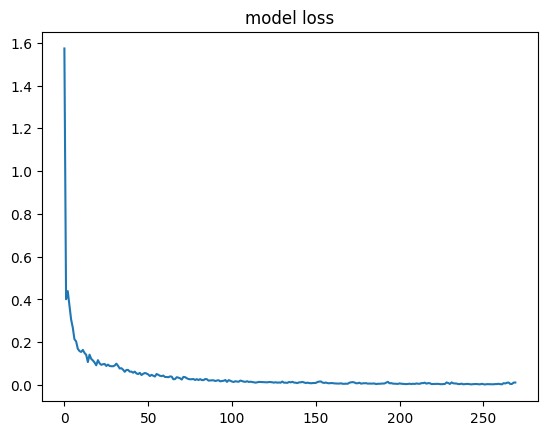

In [26]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

In [27]:
from colorama import Fore, Back, Style
 
print(Fore.RED + 'some red text')

some red text


In [36]:
colors = [Fore.BLUE,Fore.GREEN,Fore.WHITE,Fore.CYAN,Fore.RED]
reference_tag_txt = [colors[i]+dataset.uniq_tags[i] for i in range(len(dataset.uniq_tags))]
reference_tag_txt = " ".join(reference_tag_txt)

In [45]:
test_text = "aquesta setmana no presentava cap sintoma de febril."
txt_tensor = torch.tensor([dataset.vocab.index(ch) for ch in test_text]).to(device)
h, c = model.init_hidden(batch_size=1)
#unbatch so delete batch dimension
h = h.squeeze(1).to(device)
c = c.squeeze(1).to(device)

out, h, c = model.forward(txt_tensor,h,c)
out = out.cpu()
print(reference_tag_txt)
txt = ""
for i,pred in enumerate(out):
    tag_idx = np.where(pred==pred.max())[0][0]
    txt += colors[tag_idx] + test_text[i]

print(txt)

USCO UNC NONE NSCO NEG
aquesta setmana no presentava cap sintoma de febril.


In [38]:
test_text = "el paciente presenta leucoplasia severa en el dorso de la lengua."
txt_tensor = torch.tensor([dataset.vocab.index(ch) for ch in test_text]).to(device)
h, c = model.init_hidden(batch_size=1)
#unbatch so delete batch dimension
h = h.squeeze(1).to(device)
c = c.squeeze(1).to(device)

out, h, c = model.forward(txt_tensor,h,c)
out = out.cpu()

txt = ""
print(reference_tag_txt)
for i,pred in enumerate(out):
    tag_idx = np.where(pred==pred.max())[0][0]
    txt += colors[tag_idx] + test_text[i]

print(txt)

USCO UNC NONE NSCO NEG
el paciente presenta leucoplasia severa en el dorso de la lengua.


In [39]:
test_text = "el paciente no presenta leucoplasia severa en el dorso de la lengua."
txt_tensor = torch.tensor([dataset.vocab.index(ch) for ch in test_text]).to(device)
h, c = model.init_hidden(batch_size=1)
#unbatch so delete batch dimension
h = h.squeeze(1).to(device)
c = c.squeeze(1).to(device)

out, h, c = model.forward(txt_tensor,h,c)
out = out.cpu()

txt = ""
print(reference_tag_txt)
for i,pred in enumerate(out):
    tag_idx = np.where(pred==pred.max())[0][0]
    txt += colors[tag_idx] + test_text[i]

print(txt)

USCO UNC NONE NSCO NEG
el paciente no presenta leucoplasia severa en el dorso de la lengua.


In [40]:
test_text = "el pacient presenta leucoplasia severa al dorsal de la llengua."
txt_tensor = torch.tensor([dataset.vocab.index(ch) for ch in test_text]).to(device)
h, c = model.init_hidden(batch_size=1)
#unbatch so delete batch dimension
h = h.squeeze(1).to(device)
c = c.squeeze(1).to(device)

out, h, c = model.forward(txt_tensor,h,c)
out = out.cpu()

txt = ""
print(reference_tag_txt)
for i,pred in enumerate(out):
    tag_idx = np.where(pred==pred.max())[0][0]
    txt += colors[tag_idx] + test_text[i]

print(txt)

USCO UNC NONE NSCO NEG
el pacient presenta leucoplasia severa al dorsal de la llengua.


In [41]:
test_text = "el pacient no presenta leucoplasia severa al dorsal de la llengua."
txt_tensor = torch.tensor([dataset.vocab.index(ch) for ch in test_text]).to(device)
h, c = model.init_hidden(batch_size=1)
#unbatch so delete batch dimension
h = h.squeeze(1).to(device)
c = c.squeeze(1).to(device)

out, h, c = model.forward(txt_tensor,h,c)
out = out.cpu()

txt = ""
print(reference_tag_txt)

for i,pred in enumerate(out):
    tag_idx = np.where(pred==pred.max())[0][0]
    txt += colors[tag_idx] + test_text[i]

print(txt)

USCO UNC NONE NSCO NEG
el pacient no presenta leucoplasia severa al dorsal de la llengua.
